## Load ResNet

In [19]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,NormalizationCNN
import torch
import math
import time
from model import ResNet1D
import joblib
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'strong'

best_model_state_name = f"Model_state/ResNet/best_ResNet_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/CNN/strong_standard_scaler.pkl'
else:
    GJ = 73.5 # nS
    scaler_name = 'Scaler/CNN/weak_standard_scaler.pkl'

# Load the scaler
scaler = joblib.load(scaler_name)

normalize = NormalizationCNN(scaler, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            bcl=1000,
            nbeats=1,
            dt_factor=10,
            stim_amplitude=50
            )
parameters = const.parameters
Ncell = const.parameters['Ncell']
mesh_parameters = mesh_parameters.unsqueeze(1).expand(-1, Ncell)
model = ResNet1D()
best_state = torch.load(best_model_state_name)
model.load_state_dict(best_state)
model.to(device)
model.eval()

ResNet1D(
  (stem): Sequential(
    (0): Conv1d(7, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (gn1): GroupNorm(4, 32, eps=1e-05, affine=True)
      (act1): SiLU()
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (act2): SiLU()
      (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
      (out_act): SiLU()
    )
    (1): ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (gn1): GroupNorm(4, 32, eps=1e-05, affine=True)
      (act1): SiLU()
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (act2): SiLU()
      (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
      (out_act): SiLU()
    )
    (2): ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))

In [34]:
ti = 0.0
phi_i     = const.phi0.clone()
G_i       = const.g0.clone()
S         = const.S.clone()
state     = torch.cat((phi_i, G_i), dim=0)
N         = parameters['N']
phi_save  = []
I_save    = []
start     = time.time()
Ctot      =parameters['Ctot']
a         = 1
with torch.no_grad():
    while ti < const.T:

        if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
            dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
        else:
            dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

    
        if abs(math.fmod(ti, 100)) < 1e-5:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt

        #phi_i = torch.clamp(phi_i, min=-120.0, max=60.0)
        I_ID     = torch.zeros_like(phi_i,device=device,dtype=dtype)
        phi_pad  = torch.cat((phi_i.unsqueeze(0),mesh_parameters), dim=0).unsqueeze(0) # (1,7,Ncell)
        normalize_out = normalize.NormalizeInput(phi_pad)
        I_cleft = model(normalize_out)  # (1,2,Ncell-1) (*,1,*) post 
        I_cleft = normalize.DenormalizeOutput(I_cleft).squeeze(0) # (2,Ncell-1))
        I_ID[:-1] = I_cleft[0,:]
        I_ID[1:] += I_cleft[1,:]

        Iion, _, G_new, _ =  Ord11_model(ti, state, parameters, S, device, dtype)
        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break

        phi_i = state[0:N] -dt/Ctot*(Iion + 0*I_ID)
        state[0:N] = phi_i
        state[N:]  = G_new
        if abs(math.fmod(ti, dt_samp)) < 1e-8:
            phi_save.append(phi_i.clone())
            I_save.append(I_ID.clone())
        if any(torch.isnan(phi_i)):
            print('NaN detected in membrane potential!')
            breakpoint()
            break
        ti = round(ti + dt, 5) 
        # ti += dt
    end = time.time()
    phi_save = torch.stack(phi_save, dim=0)
    I_save   = torch.stack(I_save, dim=0)
    print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 100.00 ms
time: 200.00 ms
time: 300.00 ms
time: 400.00 ms
time: 500.00 ms
time: 600.00 ms
time: 700.00 ms
time: 800.00 ms
time: 900.00 ms
Simulation time: 428.62 seconds


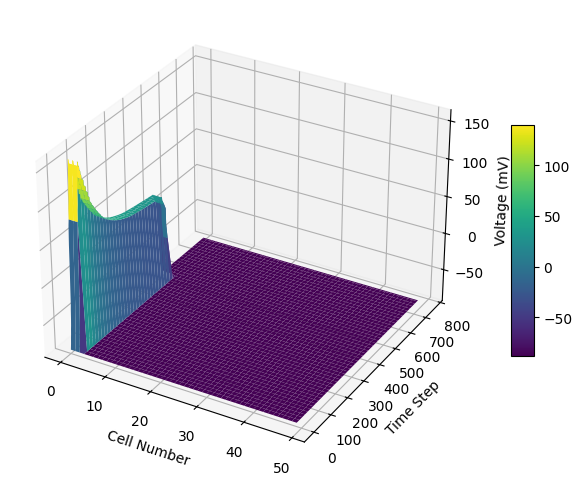

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


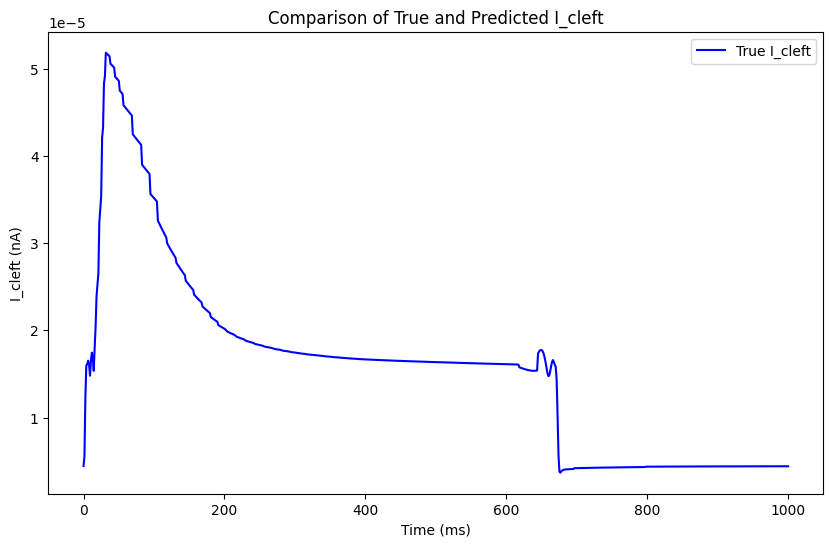

In [37]:
T = np.linspace(0, const.T, phi_save.shape[0]) # type: ignore
plt.figure(figsize=(10,6))
plt.plot(T, I_save[:,25].cpu().numpy(), label='True I_cleft', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('I_cleft (nA)')
plt.title('Comparison of True and Predicted I_cleft')
plt.legend()

## Simple resistor calculation

## Replace one Junction with CNN 

In [7]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants,NormalizationCNN
import torch
import math
import time
from model import ResNet1D
import joblib
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')
dtype = torch.float32
GJ_coupling = 'SingleGJ'

best_model_state_name = f"Model_state/ResNet/best_ResNet_{GJ_coupling}_fullseq.pth"

if GJ_coupling == 'strong':
    GJ = 735  # nS
    scaler_name = 'Scaler/CNN/strong_standard_scaler.pkl'
elif GJ_coupling == 'weak':
    GJ = 73.5 # nS
    scaler_name = 'Scaler/CNN/weak_standard_scaler.pkl'
else:
    GJ = 7.35 # nS
    scaler_name = 'Scaler/CNN/SingleGJ_standard_scaler.pkl'
# Load the scaler
scaler = joblib.load(scaler_name)
boundary = 24
slices = slice(boundary,-boundary)
normalize = NormalizationCNN(scaler, slices=slices, device=device, dtype=dtype)
mesh_parameters = torch.tensor(
    [100.0, 0.1, 0.1, 0.0, 32, 735.0],
    device=device,
    dtype=dtype
)  # d, dip, dp, Af, hip, Ggap
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            bcl=1000,
            nbeats=3,
            dt_factor=10,
            stim_amplitude=50,
            GJ_coupling=7.35e-4
            )
parameters = const.parameters
Ncell = const.parameters['Ncell']
# mesh_parameters = mesh_parameters.unsqueeze(1).expand(-1, Ncell)
model = ResNet1D(in_channels=1,out_channels=1)
best_state = torch.load(best_model_state_name)
model.load_state_dict(best_state)
model.to(device)
model.eval()
D = 0.1 # mm^2/msec
dx = 0.1 #mm    
Ctot = parameters['Ctot']
Ggap = Ctot * D / dx**2
# Ggap = parameters['Ggap']  # nS  
ti = 0.0
phi_i     = const.phi0.clone()
G_i       = const.g0.clone()
S         = const.S.clone()
state     = torch.cat((phi_i, G_i), dim=0)
N         = parameters['N']
phi_save  = []
I_save    = []
start     = time.time()
# Ctot      =parameters['Ctot']
a         = 1
bc = slices.start
I_gap = torch.zeros(N, device=device, dtype=dtype)
dt = 0.01
count = 0

with torch.no_grad():
    while ti < const.T:

        # if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
        #     dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
        # else:
        #     dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2
        if abs(math.fmod(ti, 1000)) < 1e-5:
            print(f'time: {ti:.2f} ms')
        parameters['dt'] = dt


        #phi_i = torch.clamp(phi_i, min=-120.0, max=60.0)
        # I_ID     = torch.zeros_like(phi_i,device=device,dtype=dtype)
        # phi_pad  = torch.cat((phi_i[slices].unsqueeze(0),mesh_parameters.unsqueeze(1).expand(-1, phi_i[slices].shape[0])), dim=0).unsqueeze(0) # (1,7,Ncell)
        phi_pad = phi_i[slices].reshape(1,1,-1) # (1,1,slice)
        normalize_out = normalize.NormalizeInput(phi_pad)
        I_cleft = model(normalize_out)  # (1,2,Ncell-1) (*,1,*) post 
        I_cleft = normalize.DenormalizeOutput(I_cleft).squeeze(0) # (2,Ncell-1))
        # I_gap = torch.zeros(N, device=device, dtype=dtype)

        I_gap[1:bc] = Ggap * (
            phi_i[1:bc]
        - phi_i[:bc-1]
        + phi_i[1:bc]
        - phi_i[2:bc+1]
        )

        I_gap[-bc:-1] = Ggap * (
            phi_i[-bc:-1]
        - phi_i[-bc-1:-2]
        + phi_i[-bc:-1]
        - phi_i[-bc+1:]
        )

        I_gap[0]  = Ggap * (phi_i[0]  - phi_i[1])
        I_gap[-1] = Ggap * (phi_i[-1] - phi_i[-2])

        I_gap[bc]     = Ggap * (phi_i[bc]     - phi_i[bc-1])
        I_gap[-bc-1]  = Ggap * (phi_i[-bc-1]  - phi_i[-bc])

        I_gap[bc:-bc-1]   += -I_cleft[0, :]
        I_gap[bc+1:-bc]   += I_cleft[0, :]

        Iion, _, G_new, _ =  Ord11_model(ti, state, parameters, S, device, dtype)
        if torch.isnan(Iion).any():
            print('NaN already in Iion! time:', ti)
            break

        phi_i = state[0:N] -dt/Ctot*(Iion + I_gap)
        state[0:N] = phi_i
        state[N:]  = G_new
        # 
        if count % 100 == 0:
            phi_save.append(phi_i.clone())
            I_save.append(I_gap.clone())
        if any(torch.isnan(phi_i)):
            print('NaN detected in membrane potential!')
            breakpoint()
            break
        # ti = round(ti + dt, 5) 
        ti += dt
        count += 1
    end = time.time()
    phi_save = torch.stack(phi_save, dim=0)
    I_save   = torch.stack(I_save, dim=0)
    print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
Simulation time: 829.32 seconds


In [18]:
I_gap[bc+1:-bc]

tensor([-2.3912e-05])

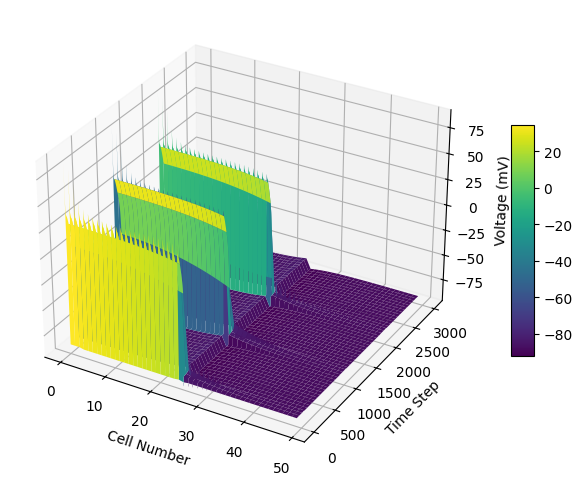

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# phi_save: shape (T_steps, N_cells)
data = phi_save.cpu().numpy()

T_steps, N_cells = data.shape

X = np.arange(T_steps)[:, None]           # time step axis
Y = np.arange(N_cells)[None, :]           # cell axis

X_grid, Y_grid = np.meshgrid(np.arange(N_cells),
                             np.arange(T_steps))

Z = data   # voltage


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X_grid, Y_grid, Z,
                       cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel("Cell Number")
ax.set_ylabel("Time Step")
ax.set_zlabel("Voltage (mV)")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


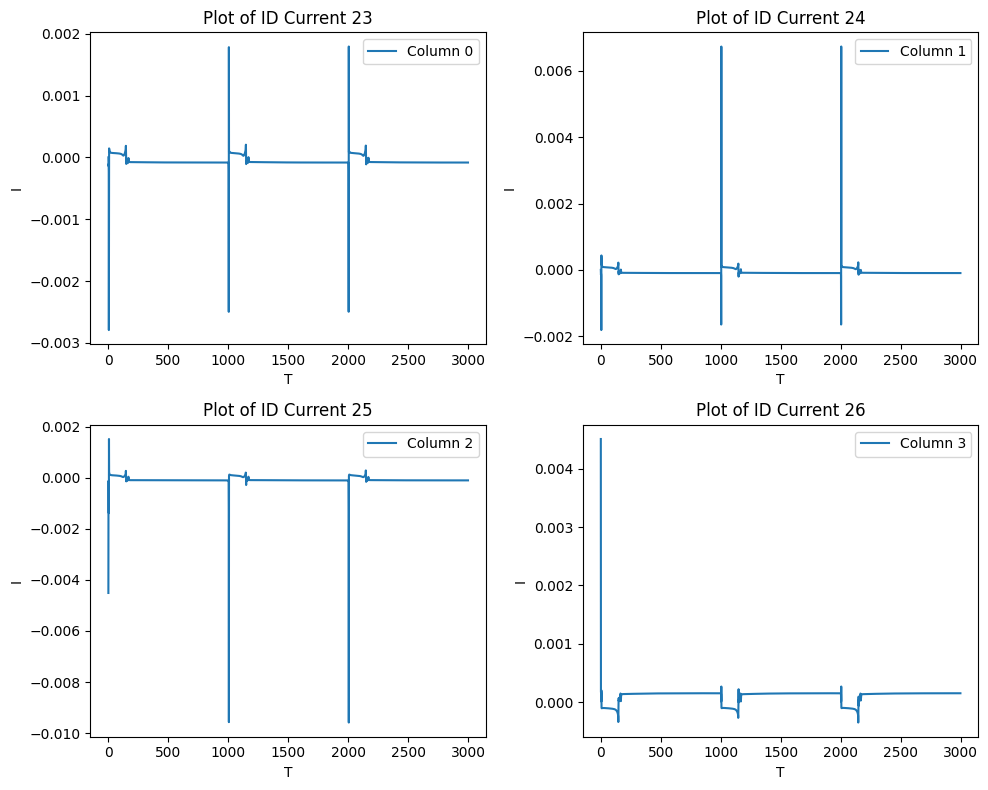

In [9]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(2, 2, figsize=(10, 8))

data_to_plot = I_save

axes = axes.flatten()

for i in range(4):
    axes[i].plot(data_to_plot[:, i+22], label=f'Column {i}')
    axes[i].set_title(f'Plot of ID Current {i+1+22}')
    axes[i].set_xlabel('T')
    axes[i].set_ylabel('I')
    axes[i].legend()

plt.tight_layout()

plt.show() 
# plt.savefig('2x2_subplots_I_save.png')

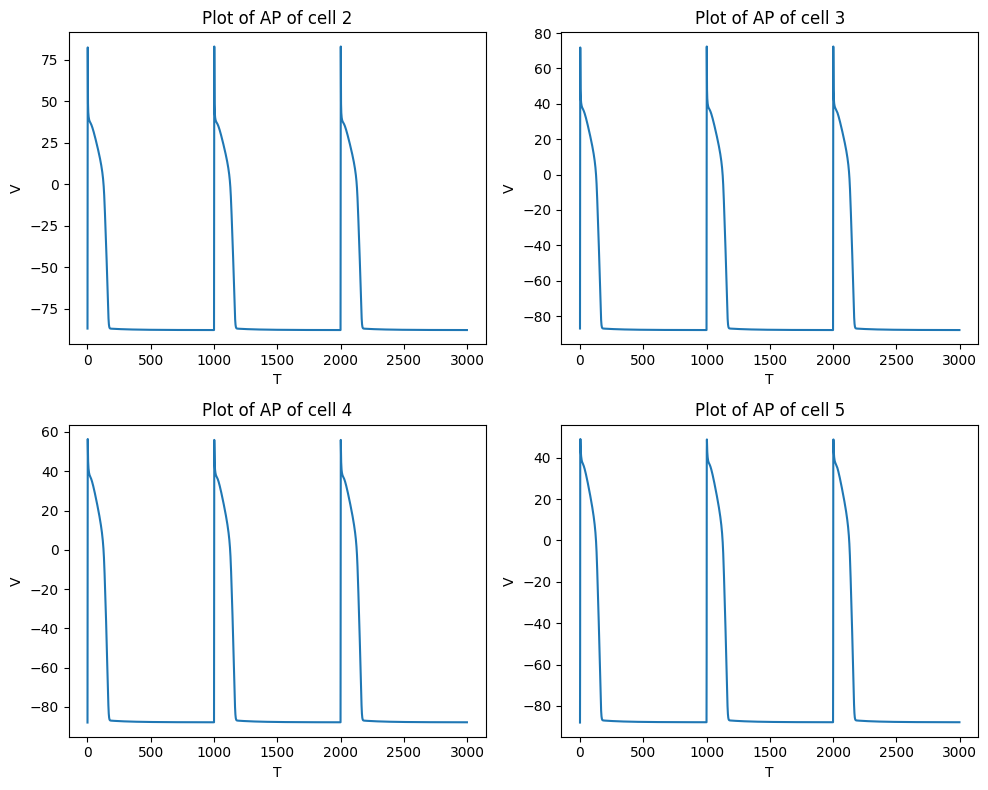

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

idx = np.array([1,2,3,4])

for axi,i in enumerate(idx):
    axes[axi].plot(phi_save[:, i])
    axes[axi].set_title(f'Plot of AP of cell {i+1}')
    axes[axi].set_xlabel('T')
    axes[axi].set_ylabel('V')

plt.tight_layout()

plt.show() 

### Test Simple resistor coupling

In [1]:
from simulator import *
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
from model import ResNet1D

device = torch.device('cpu')
dtype = torch.float32
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=50,
            bcl=1000,
            nbeats=3,
            dt_factor=10,
            stim_amplitude=50,
            GJ_coupling=7.35e-4
            )
D = 0.1 # mm^2/msec
dx = 0.1 #mm    
Ctot = const.parameters['Ctot']
Ggap = Ctot * D / dx**2
model = ResNet1D(in_channels=1,out_channels=1)
# coupling = ResistorCoupling(const.parameters['Ncell'], Ggap, device=device, dtype=dtype)
# sim = CableSimulator(const, coupling, Ord11_model_fn=Ord11_model, device=device, dtype=dtype)

# t_save, phi_save, I_save = sim.run()

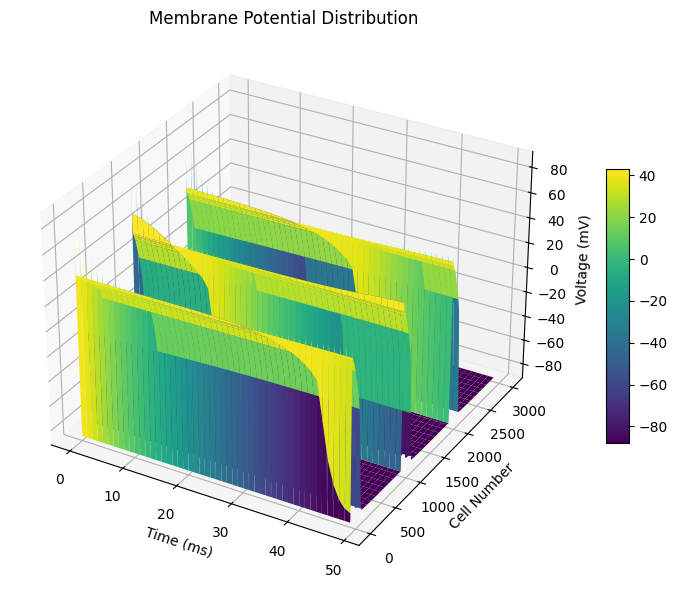

In [6]:
from Plot import Plot_fn

Plot_fn.plot_2D_map(t_save, phi_save, title='Membrane Potential Distribution', xlabel='Time (ms)', ylabel='Cell Number', zlabel='Voltage (mV)')

In [4]:
coupling = NNSimpleCoupling(const.parameters['Ncell'], Ggap, 24, model, model_name='ResNet', if_normalize=True, device=device, dtype=dtype)
sim = CableSimulator(const, coupling, Ord11_model_fn=Ord11_model, device=device, dtype=dtype)
t_save, phi_save, I_save = sim.run()

time: 0.00 ms, dt=0.001
Simulation time: 1130.14 seconds


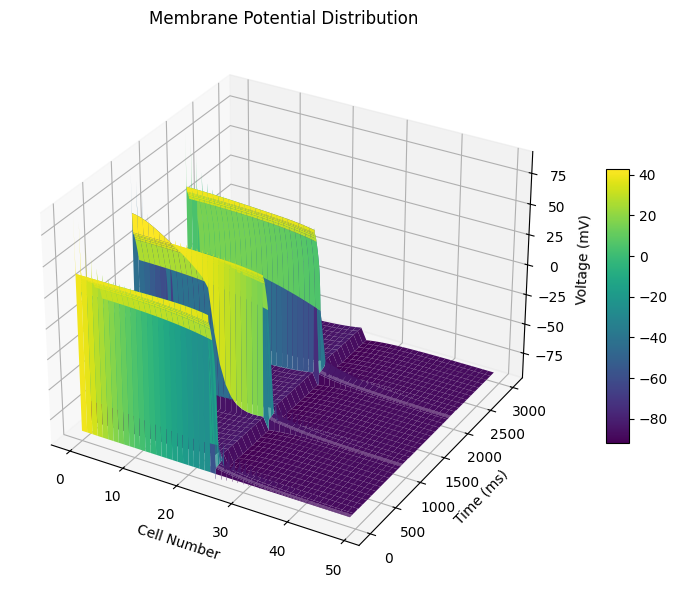

In [5]:
from Plot import Plot_fn

Plot_fn.plot_2D_map(t_save, phi_save, title='Membrane Potential Distribution', xlabel='Cell Number', ylabel='Time (ms)', zlabel='Voltage (mV)')